In [1]:

# import the weight_searcher object
from optweights.weight_searcher import WeightSearcher

# import the logistic regression model from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification

# import numpy
import numpy as np

# create some arbitrary data
n, d, k = 2000, 100, 2
X, y = make_classification(
    n_samples=n,
    n_features=d,
    n_classes=k,
    random_state=42,
)
g = np.random.binomial(1, 0.5, size=n) + 1
y, g = y.reshape(-1, 1), g.reshape(-1, 1)

# make a train/validation split for the data
n_train = int(n * 0.8)
X_train, y_train, g_train = X[:n_train], y[:n_train], g[:n_train]
X_val, y_val, g_val = X[n_train:], y[n_train:], g[n_train:]

# create a logistic regression model
model_param  = {'max_iter': 100,
                'penalty': 'l1',
                'C': 1,
                'solver': 'liblinear',
                'tol': 1e-4,
                'verbose': 0,
                'random_state': 0,
                'fit_intercept': True, 
                'warm_start': False}
logreg = LogisticRegression(**model_param)


In [2]:

# train a g classifier
g_classifier = LogisticRegression(**model_param)
g_classifier.fit(X_train, g_train)
g_prob = g_classifier.predict_proba(X_train)

# I assume the first column is g=1, second g=2, etc. 
print(g_prob.shape)


(1600, 2)


/Users/anastasiaanastasiadou/Downloads/base-optweights-main/.env/lib/python3.11/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [3]:

# Define the probability of each group in the distribution of interest
# This is a case where we have two groups, and each group is given equal weight
p_ood = {1: 0.5, 2: 0.5}

# create a weight searcher object
ws = WeightSearcher(X_train, y_train, g_train, X_val, y_val, g_val, # define the X, y, g for both train/val
                        p_ood=p_ood,                                 # define the distribution of interest
                        sklearn_model=logreg,                        # define the sklearn model (optional)
                     )

# set the g_prob
ws.set_g_prob(g_prob)

# define the arguments for the optimization
T = 100             # the number of steps
lr = 0.1            # the learning rate
momentum = 0.5      # the momentum parameter - higher is more momentum
patience=5

# optimize the weights
p_hat =  ws.optimize_weights(T,  lr,  momentum, patience=patience)

# get the weights for the training set - these can then be used subsequently for an estimator. 
w_train = ws.return_weights(p_hat, g_train)

At step 0, the loss is 0.2977, we have 5 patience left, and the probabilities are {1: 0.5, 2: 0.5}, which sum to 1.0000 with gradients {1: -0.0037, 2: 0.0037}.
The model is updated in 0.6957340240478516 seconds
At step 1, the loss is 0.2977, we have 5 patience left, and the probabilities are {1: 0.5001, 2: 0.4999}, which sum to 1.0000 with gradients {1: -0.0037, 2: 0.0037}.
The model is updated in 0.6888651847839355 seconds
At step 2, the loss is 0.2977, we have 5 patience left, and the probabilities are {1: 0.5003, 2: 0.4997}, which sum to 1.0000 with gradients {1: -0.0037, 2: 0.0037}.
The model is updated in 0.6757698059082031 seconds
At step 3, the loss is 0.2977, we have 5 patience left, and the probabilities are {1: 0.5005, 2: 0.4995}, which sum to 1.0000 with gradients {1: -0.0037, 2: 0.0037}.
The model is updated in 0.6780920028686523 seconds
At step 4, the loss is 0.2977, we have 5 patience left, and the probabilities are {1: 0.5007, 2: 0.4993}, which sum to 1.0000 with gradien

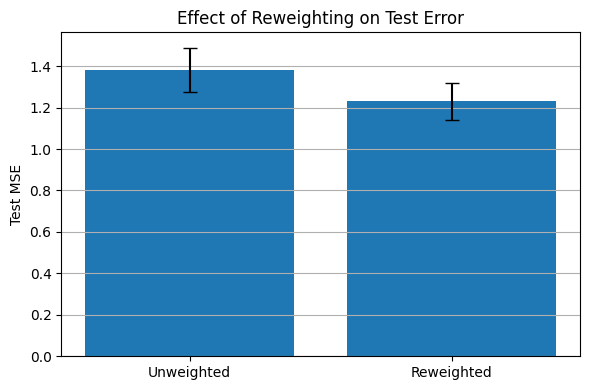

In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Re-define data generation functions
def generate_subset(n: int, p: float, beta: float,
                   sigma_1: float, sigma_0: float, mu, gamma,
                   a_0: float, a_1: float, d: int):
    Sigma = np.diag(np.ones(d)) * gamma
    X = np.random.multivariate_normal(mu, Sigma, n)

    g = np.zeros(n)
    n_1 = int(np.round(n * p))
    n_0 = n - n_1
    i_1 = np.random.choice(n, n_1, replace=False)
    g[i_1] = 1

    y = np.zeros(n)

    X_1 = X[g == 1]
    eps_1 = np.random.normal(0, np.sqrt(sigma_1), n_1).reshape(-1, 1)
    B_1 = np.zeros((d, 1))
    B_1[0] = beta
    y_1 = np.matmul(X_1, B_1) + a_1 + eps_1
    y[g == 1] = y_1.squeeze(-1)

    X_0 = X[g == 0]
    eps_0 = np.random.normal(0, np.sqrt(sigma_0), n_0).reshape(-1, 1)
    B_0 = np.zeros((d, 1))
    B_0[0] = beta
    y_0 = np.matmul(X_0, B_0) + a_0 + eps_0
    y[g == 0] = y_0.squeeze(-1)

    y = y.reshape(-1, 1)
    g = g.reshape(-1, 1)

    return X, y, g

def generate_toy_dataset(n: int, p_tr: float, p_te: float, beta: float,
                         sigma_1: float, sigma_0: float, intercept_diff: float, d: int):
    mu = np.zeros(d)
    gamma = 1.0
    a_0 = 0.0
    a_1 = a_0 + intercept_diff

    n_train = int(0.6 * n)
    n_val = int(0.2 * n)
    n_test = n - n_train - n_val

    X_train, y_train, g_train = generate_subset(n_train, p_tr, beta, sigma_1, sigma_0, mu, gamma, a_0, a_1, d)
    X_val, y_val, g_val = generate_subset(n_val, p_tr, beta, sigma_1, sigma_0, mu, gamma, a_0, a_1, d)
    X_test, y_test, g_test = generate_subset(n_test, p_te, beta, sigma_1, sigma_0, mu, gamma, a_0, a_1, d)

    return X_train, X_val, X_test, y_train, y_val, y_test, g_train, g_val, g_test

# Run the simulation framework
def run_simulation(n=1000, d=5, p_tr=0.7, p_te=0.3, beta=1.0, intercept_diff=1.0,
                   sigma_0=1.0, sigma_1=1.0, n_trials=50, reweight=False):
    mse_list = []

    for seed in range(n_trials):
        np.random.seed(seed)

        data = generate_toy_dataset(n=n, p_tr=p_tr, p_te=p_te, beta=beta,
                                     sigma_0=sigma_0, sigma_1=sigma_1,
                                     intercept_diff=intercept_diff, d=d)

        X_train, X_val, X_test, y_train, y_val, y_test, g_train, g_val, g_test = data

        X_train_aug = np.c_[np.ones(X_train.shape[0]), X_train]
        X_test_aug = np.c_[np.ones(X_test.shape[0]), X_test]

        if reweight:
            p_train_1 = np.mean(g_train)
            p_test_1 = np.mean(g_test)
            p_train_0 = 1 - p_train_1
            p_test_0 = 1 - p_test_1
            w = np.where(g_train.flatten() == 1, p_test_1 / p_train_1, p_test_0 / p_train_0)
        else:
            w = None

        model = LinearRegression()
        model.fit(X_train_aug, y_train, sample_weight=w)

        y_pred = model.predict(X_test_aug)
        mse = mean_squared_error(y_test, y_pred)
        mse_list.append(mse)

    return np.mean(mse_list), np.std(mse_list)

# Execute and compare unweighted vs weighted results
mean_mse_unweighted, std_mse_unweighted = run_simulation(reweight=False)
mean_mse_weighted, std_mse_weighted = run_simulation(reweight=True)

# Plot
labels = ['Unweighted', 'Reweighted']
means = [mean_mse_unweighted, mean_mse_weighted]
errors = [std_mse_unweighted, std_mse_weighted]

plt.figure(figsize=(6, 4))
plt.bar(labels, means, yerr=errors, capsize=5)
plt.ylabel('Test MSE')
plt.title('Effect of Reweighting on Test Error')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [4]:
# First, define the simplex projection function for weight updates
def project_to_simplex(p):
    """ Project weights to the probability simplex using sorting-based algorithm """
    p = np.maximum(p, 0)
    u = np.sort(p)[::-1]
    cssv = np.cumsum(u)
    rho = np.where(u > (cssv - 1) / (np.arange(len(p)) + 1))[0][-1]
    theta = (cssv[rho] - 1) / (rho + 1)
    return np.maximum(p - theta, 0)

# Define the optimizer loop for group weights
def optimize_group_weights(weight_searcher, X_train, y_train, g_train,
                           X_val, y_val, model, q_soft, p_train, p_init,
                           n_steps=20, lr=0.1):
    """
    Perform projected gradient descent to optimize group weights using IFT gradient.
    """
    # Set soft group probabilities
    weight_searcher.set_g_prob(q_soft)
    
    # Current weights (p)
    p = p_init.copy()

    for _ in range(n_steps):
        # Update Weights object with current p
        p_w = {g: p[g] for g in range(len(p))}
        weight_searcher.reset_weights(p_w)

        # Compute importance weights for validation (p_test / p_train)
        p_val = {0: 0.5, 1: 0.5}  # assume balanced test groups
        w_val = np.where(g_val.flatten() == 1,
                         p_val[1] / p_train[1],
                         p_val[0] / p_train[0])

        # Compute gradient via IFT
        grad = weight_searcher.weight_grad_via_ift(
            X_train, y_train, g_train, X_val, y_val, model, w_val
        )

        # Update and project
        p = p - lr * grad
        p = project_to_simplex(p)

    return p


In [5]:

def generate_subset(n: int, p: float, beta: float, sigma_1: float, sigma_0: float, mu, gamma,
                   a_0: float, a_1: float, d: int):
    Sigma = np.diag(np.ones(d)) * gamma
    X = np.random.multivariate_normal(mu, Sigma, n)
    g = np.zeros(n)
    n_1 = int(np.round(n * p))
    i_1 = np.random.choice(n, n_1, replace=False)
    g[i_1] = 1
    y = np.zeros(n)

    X_1 = X[g == 1]
    eps_1 = np.random.normal(0, np.sqrt(sigma_1), n_1).reshape(-1, 1)
    B_1 = np.zeros((d, 1))
    B_1[0] = beta
    y_1 = np.matmul(X_1, B_1) + a_1 + eps_1
    y[g == 1] = y_1.squeeze(-1)

    X_0 = X[g == 0]
    eps_0 = np.random.normal(0, np.sqrt(sigma_0), n - n_1).reshape(-1, 1)
    B_0 = np.zeros((d, 1))
    B_0[0] = beta
    y_0 = np.matmul(X_0, B_0) + a_0 + eps_0
    y[g == 0] = y_0.squeeze(-1)

    return X, y.reshape(-1, 1), g.reshape(-1, 1)

def generate_toy_dataset(n, p_tr, p_te, beta, sigma_1, sigma_0, intercept_diff, d):
    mu = np.zeros(d)
    gamma = 1.0
    a_0 = 0.0
    a_1 = a_0 + intercept_diff
    n_train, n_val = int(0.6 * n), int(0.2 * n)
    n_test = n - n_train - n_val

    X_train, y_train, g_train = generate_subset(n_train, p_tr, beta, sigma_1, sigma_0, mu, gamma, a_0, a_1, d)
    X_val, y_val, g_val = generate_subset(n_val, p_tr, beta, sigma_1, sigma_0, mu, gamma, a_0, a_1, d)
    X_test, y_test, g_test = generate_subset(n_test, p_te, beta, sigma_1, sigma_0, mu, gamma, a_0, a_1, d)

    return X_train, X_val, X_test, y_train, y_val, y_test, g_train, g_val, g_test


In [6]:

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np

def run_simulation_with_consistent_group_labels(n=2000, d=10, p_tr=0.7, p_te=0.3, beta=1.0, intercept_diff=1.0,
                                                 sigma_0=1.0, sigma_1=1.0, n_trials=5, T=100, lr=0.1,
                                                 momentum=0.5, patience=5):
    results = {'Unweighted': [], 'Analytical': [], 'Optimized': []}

    for trial in range(n_trials):
        np.random.seed(trial)
        data = generate_toy_dataset(n=n, p_tr=p_tr, p_te=p_te, beta=beta,
                                    sigma_0=sigma_0, sigma_1=sigma_1,
                                    intercept_diff=intercept_diff, d=d)
        X_train, X_val, X_test, y_train, y_val, y_test, g_train, g_val, g_test = data
        g_train, g_val = g_train.astype(int) + 1, g_val.astype(int) + 1

        median_threshold = np.median(y_train)
        y_train_bin = (y_train > median_threshold).astype(int)
        y_val_bin = (y_val > median_threshold).astype(int)
        y_test_bin = (y_test > median_threshold).astype(int)

        g_classifier = LogisticRegression(solver='liblinear')
        g_classifier.fit(X_train, g_train.ravel())
        g_prob = g_classifier.predict_proba(X_train)
        class_order = g_classifier.classes_
        g_to_idx = {g: i for i, g in enumerate(class_order)}
        g_prob_ordered = np.zeros_like(g_prob)
        for g, i in g_to_idx.items():
            g_prob_ordered[:, g - 1] = g_prob[:, i]

        p_train = {g: np.mean(g_train == g) for g in class_order}
        p_test = {1: p_te, 2: 1 - p_te}

        clf1 = LogisticRegression(solver='liblinear')
        clf1.fit(X_train, y_train_bin.ravel())
        acc1 = accuracy_score(y_test_bin, clf1.predict(X_test))
        results['Unweighted'].append(acc1)

        w_analytical = np.where(g_train.flatten() == 1,
                                p_test[1] / p_train[1],
                                p_test[2] / p_train[2])
        clf2 = LogisticRegression(solver='liblinear')
        clf2.fit(X_train, y_train_bin.ravel(), sample_weight=w_analytical)
        acc2 = accuracy_score(y_test_bin, clf2.predict(X_test))
        results['Analytical'].append(acc2)

        from optweights.weight_searcher import WeightSearcher
        ws = WeightSearcher(X_train, y_train_bin, g_train, X_val, y_val_bin, g_val,
                            p_ood=p_test, sklearn_model=LogisticRegression(solver='liblinear'))
        ws.set_g_prob(g_prob_ordered)
        p_hat = ws.optimize_weights(T=T, lr=lr, momentum=momentum, patience=patience)
        w_opt = ws.return_weights(p_hat, g_train)
        clf3 = LogisticRegression(solver='liblinear')
        clf3.fit(X_train, y_train_bin.ravel(), sample_weight=w_opt)
        acc3 = accuracy_score(y_test_bin, clf3.predict(X_test))
        results['Optimized'].append(acc3)

    return results


At step 0, the loss is 0.5367, we have 5 patience left, and the probabilities are {1: 0.3, 2: 0.7}, which sum to 1.0000 with gradients {1: 0.0002, 2: -0.0002}.
The model is updated in 0.0016183853149414062 seconds
At step 1, the loss is 0.5367, we have 4 patience left, and the probabilities are {1: 0.3, 2: 0.7}, which sum to 1.0000 with gradients {1: 0.0002, 2: -0.0002}.
The model is updated in 0.001277923583984375 seconds
At step 2, the loss is 0.5367, we have 3 patience left, and the probabilities are {1: 0.3, 2: 0.7}, which sum to 1.0000 with gradients {1: 0.0002, 2: -0.0002}.
The model is updated in 0.0012979507446289062 seconds
At step 3, the loss is 0.5367, we have 2 patience left, and the probabilities are {1: 0.3, 2: 0.7}, which sum to 1.0000 with gradients {1: 0.0002, 2: -0.0002}.
The model is updated in 0.001237630844116211 seconds
At step 4, the loss is 0.5367, we have 1 patience left, and the probabilities are {1: 0.3, 2: 0.7}, which sum to 1.0000 with gradients {1: 0.0002,

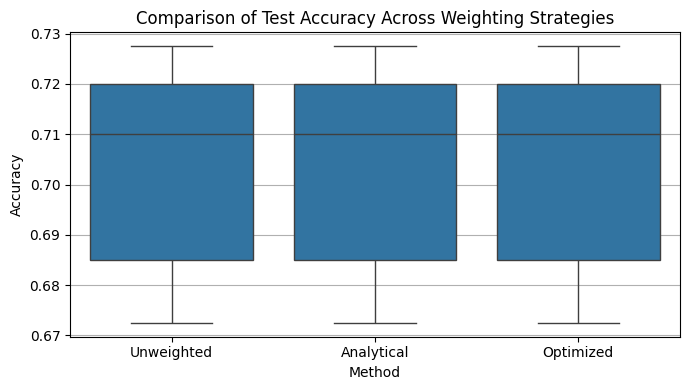

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

results = run_simulation_with_consistent_group_labels()
df = pd.DataFrame(results)
df_melted = df.melt(var_name='Method', value_name='Accuracy')
plt.figure(figsize=(7, 4))
sns.boxplot(x='Method', y='Accuracy', data=df_melted)
plt.title("Comparison of Test Accuracy Across Weighting Strategies")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()
